# 0. Import neccesary libraries

In [13]:
import os
import math
import torch
from torchvision.transforms import Compose
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

# 1. Create Spectrograms

In [2]:
class MUSDB18Spectrogram:
    """
    Class to compute and visualize spectrograms of audio files.

    Args:
        spectrogram_tensor (torch.Tensor): Tensor containing spectrogram data of shape (2, F, T),
                                           where F represents the frequency bins and T represents the time bins.
        name (str, optional): Name of the audio file. Default is 'NONAME'.

    Attributes:
        mix (torch.Tensor): Spectrogram tensor for the audio mixture (shape: (1, F, T)).
        voc (torch.Tensor): Spectrogram tensor for the isolated vocals (shape: (1, F, T)).
        mask (torch.Tensor): Mask spectrogram computed as vocals / mixture (shape: (1, F, T)).
        t (torch.Tensor): Time bins of the spectrogram.
        f (torch.Tensor): Frequency bins of the spectrogram.
        name (str): Name of the audio file.

    Methods:
        visualize(): Visualizes the mixture, vocals, and mask spectrograms.
    """
    def __init__(self, spectrogram_tensor: torch.tensor, name: str='NONAME'):
        """
        Initializes the MUSDB18Spectrogram object.
        """
        self.mix = spectrogram_tensor[0,:,:][None, :]
        self.voc = spectrogram_tensor[1,:,:][None, :]
        self.mask = torch.nan_to_num(torch.div(spectrogram_tensor[1,:,:], spectrogram_tensor[0,:,:])[None, :])
        self.t = torch.arange(self.mix.shape[2])  # Time bins
        self.f = torch.arange(self.mix.shape[1])  # Frequency bins
        self.name = name

    def visualize(self):
        """
        Visualize the mixture, vocals, and mask spectrograms.
        """
        # Plot the spectrograms
        fig, axes = plt.subplots(3, 1, figsize=(20, 15))

        # Plot the mixture spectrogram
        im1 = axes[0].pcolormesh(self.t, self.f, self.mix[0], cmap='inferno')  # Applying log scale for better visualization
        axes[0].set_ylabel('Frequency bin F (Hz)')
        axes[0].set_xlabel('Samples T (s)')
        axes[0].set_title(f'Mixture Spectrogram of {self.name}')
        plt.colorbar(im1, ax=axes[0], label='Intensity (dB)')  # Add colorbar to the subplot

        # Plot the vocals spectrogram
        im2 = axes[1].pcolormesh(self.t, self.f, self.voc[0], cmap='inferno')  # Applying log scale for better visualization
        axes[1].set_ylabel('Frequency bin F (Hz)')
        axes[1].set_xlabel('Samples T (s)')
        axes[1].set_title(f'Vocals Spectrogram of {self.name}')
        plt.colorbar(im2, ax=axes[1], label='Intensity (dB)')  # Add colorbar to the subplot

        # Plot the mask spectrogram
        im3 = axes[2].pcolormesh(self.t, self.f, self.mask[0], cmap='inferno')  # Applying log scale for better visualization
        axes[2].set_ylabel('Frequency bin F (Hz)')
        axes[2].set_xlabel('Samples T (s)')
        axes[2].set_title(f'Mask Spectrogram of {self.name}')
        plt.colorbar(im3, ax=axes[2], label='Intensity (dB)')  # Add colorbar to the subplot

        # Display the plot
        plt.show()



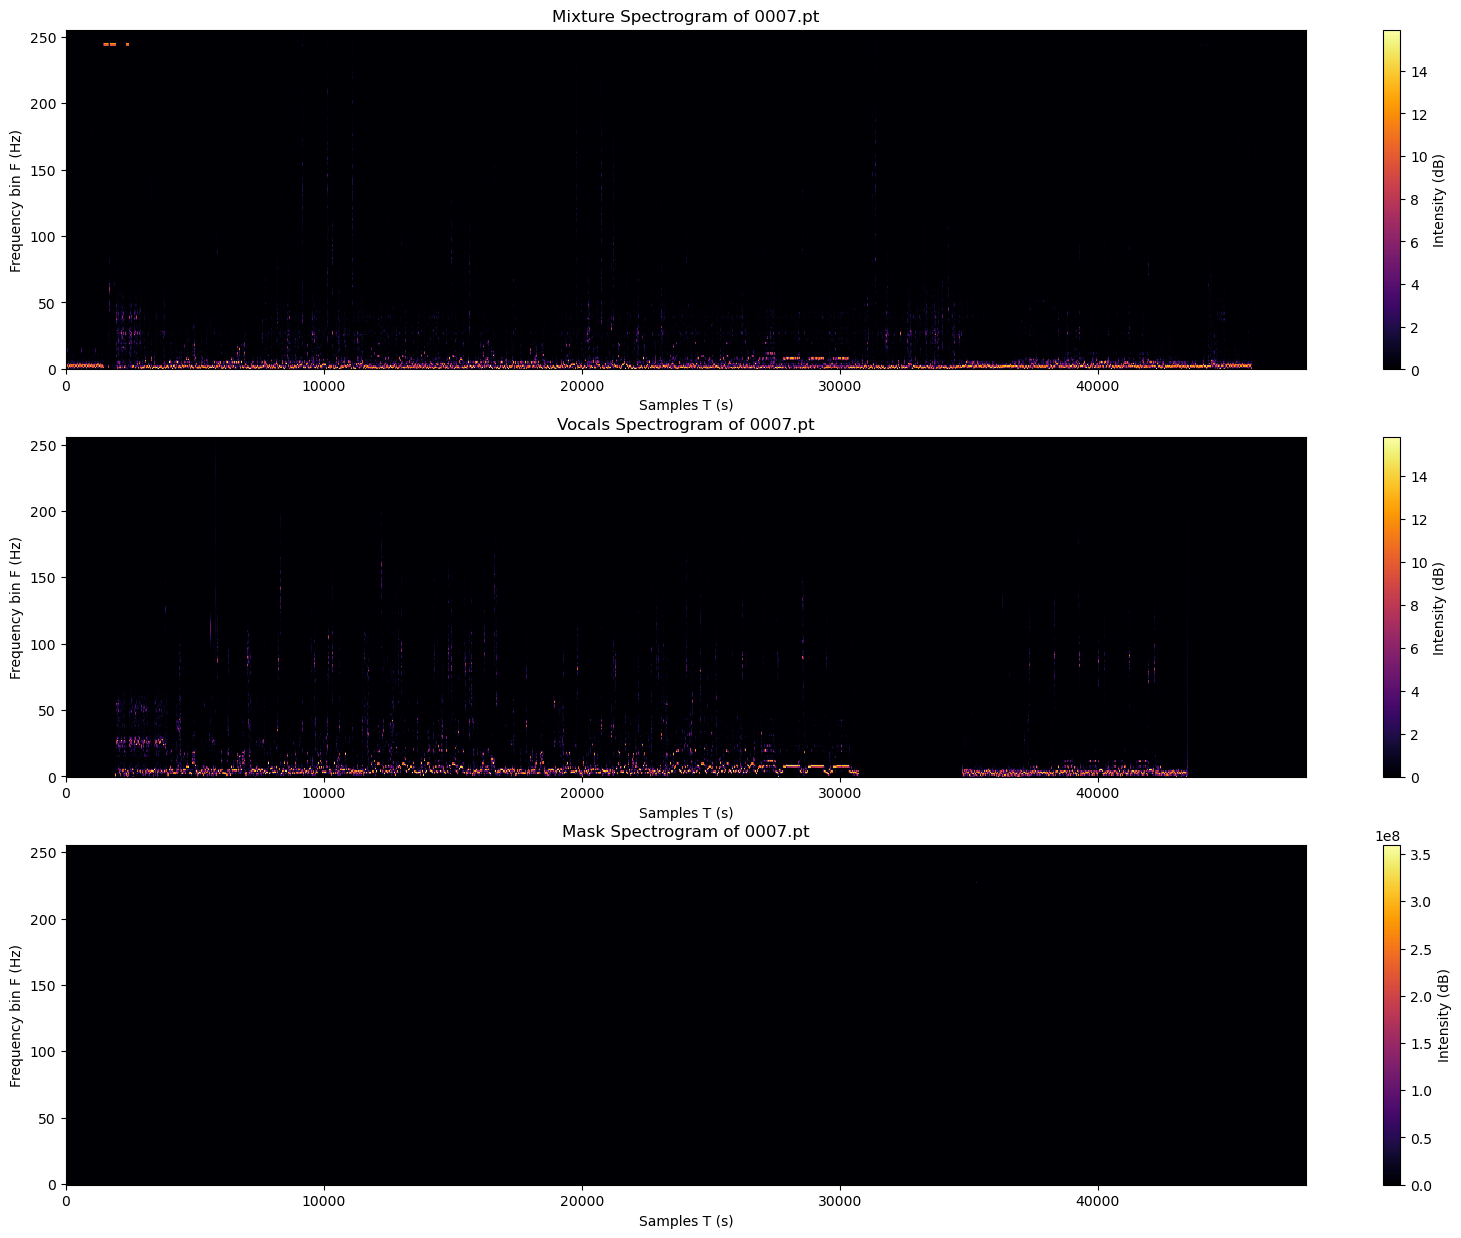

torch.Size([1, 256, 48077])

In [3]:
filename = './music_data/musdb18hq_processed/train_spectrograms/0007.pt'
spectrogram_tensor = torch.load(filename)
my_spectrogram = MUSDB18Spectrogram(spectrogram_tensor, filename[-7:])
my_spectrogram.visualize()

my_spectrogram.voc.shape

# 2. Create Dataset

In [4]:
class MUSDB18Dataset(Dataset):
    """
    Dataset class for MUSDB18 spectrograms.

    Args:
        root (str): Root directory containing the spectrogram files.
        transform (callable, optional): Optional transform to be applied to the spectrogram samples.
                                        It can be used for data augmentation or preprocessing.
                                        Defaults to None.

    Attributes:
        root (str): Root directory containing the spectrogram files.
        transform (callable): Optional transform to be applied to the spectrogram samples.
        data (list): List to store processed spectrogram samples.
        samples_per_data (int): Number of samples per spectrogram file.

    Methods:
        __init__(self, root: str, transform=None):
            Initializes the MUSDB18Dataset object.
            Loads and processes the MUSDB18 dataset stored as spectrograms in the specified `root` directory.
            Each file in the directory is expected to contain precomputed spectrogram data for audio tracks.
            Raises:
                FileNotFoundError: If the specified `root` directory does not exist.

        __getitem__(self, index: int):
            Get sample by index.
            Args:
                index (int): Index of the sample to retrieve.
            Returns:
                tuple: A tuple containing the mixture and vocals spectrogram samples.

        __len__(self):
            Total number of samples in the dataset.
            Returns:
                int: Number of samples in the dataset.

        show_spectrogram(self, index: int):
            Visualize the mixture and vocals spectrograms for the given index.
            Args:
                index (int): Index of the sample to visualize.
    """

    def __init__(self, root: str, transform=None):
        """
        Initializes the MUSDB18Dataset object.

        Loads and processes the MUSDB18 dataset stored as spectrograms in the specified `root` directory.
        Each file in the directory is expected to contain precomputed spectrogram data for audio tracks.

        Args:
            root (str): Root directory containing the spectrogram files.
            transform (callable, optional): Optional transform to be applied to the spectrogram samples.
                                            It can be used for data augmentation or preprocessing.
                                            Defaults to None.

        Raises:
            FileNotFoundError: If the specified `root` directory does not exist.
        """
        if not os.path.exists(root):
            raise FileNotFoundError(f"Directory '{root}' not found.")

        self.root = root
        self.transform = transform
        self.data = []  # List to store processed spectrogram samples
        self.samples_per_data = 256  # Number of samples per spectrogram file

        # Iterate through files in the root directory
        for filename in os.listdir(self.root):
            # Load and process the spectrogram data from each file
            spectrogram_tensor = torch.load(os.path.join(self.root, filename))
            
            # Divide the spectrogram into segments of size `samples_per_data`
            for i in range(math.floor(spectrogram_tensor.shape[2] / self.samples_per_data)):
                # Extract a segment of the spectrogram
                segment_tensor = spectrogram_tensor[:, :, i * self.samples_per_data:(i + 1) * self.samples_per_data]
                
                # Create a new MUSDB18Spectrogram object with the segment and filename information
                new_tens = MUSDB18Spectrogram(segment_tensor, f'{filename}, part {i}')
                
                # Add the processed spectrogram segment to the dataset
                self.data.append(new_tens)

    def __getitem__(self, index: int):
        """
        Get sample by index.

        Args:
            index (int): Index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the mixture and vocals spectrogram samples.
        """
        # Access the stored path and label for the correct index
        spectrogram = self.data[index]

        if self.transform is not None:
            return self.transform(spectrogram.mix), self.transform(spectrogram.mask)
        else:
            return spectrogram.mix, spectrogram.mask
    
    def __len__(self):
        """
        Total number of samples in the dataset.

        Returns:
            int: Number of samples in the dataset.
        """
        return len(self.data)
    
    def show_spectrogram(self, index: int):
        """
        Visualize the mixture and vocals spectrograms for the given index.

        Args:
            index (int): Index of the sample to visualize.
        """
        spectrogram_object = self.data[index]
        if self.transform is not None:
            mix = self.transform(spectrogram_object.mix)
            voc = self.transform(spectrogram_object.voc)
        else:
            mix = spectrogram_object.mix
            voc = spectrogram_object.voc
        MUSDB18Spectrogram(torch.cat((mix, voc), 0), self.data[index].name).visualize()
        
        

In [5]:
from torchvision.transforms import Normalize, GaussianBlur, ToTensor

train_spectrogram_library = './music_data/musdb18hq_processed/train_spectrograms/'
val_spectrogram_library = './music_data/musdb18hq_processed/val_spectrograms/'
test_spectrogram_library = './music_data/musdb18hq_processed/test_spectrograms/'
cpu_train_spectrogram_library = './music_data/musdb18hq_processed/cpu_train_spectrograms/'

mean = [0.485]
std = [0.229] 

transform_composition = Compose([Normalize(mean=mean,std=std), GaussianBlur(5)])
#music_dataset_train = MUSDB18Dataset(train_spectrogram_library, transform_composition)
#music_dataset_val = MUSDB18Dataset(val_spectrogram_library, transform_composition)
#music_dataset_test = MUSDB18Dataset(test_spectrogram_library, transform_composition)
music_dataset_cpu = MUSDB18Dataset(cpu_train_spectrogram_library, transform=None)


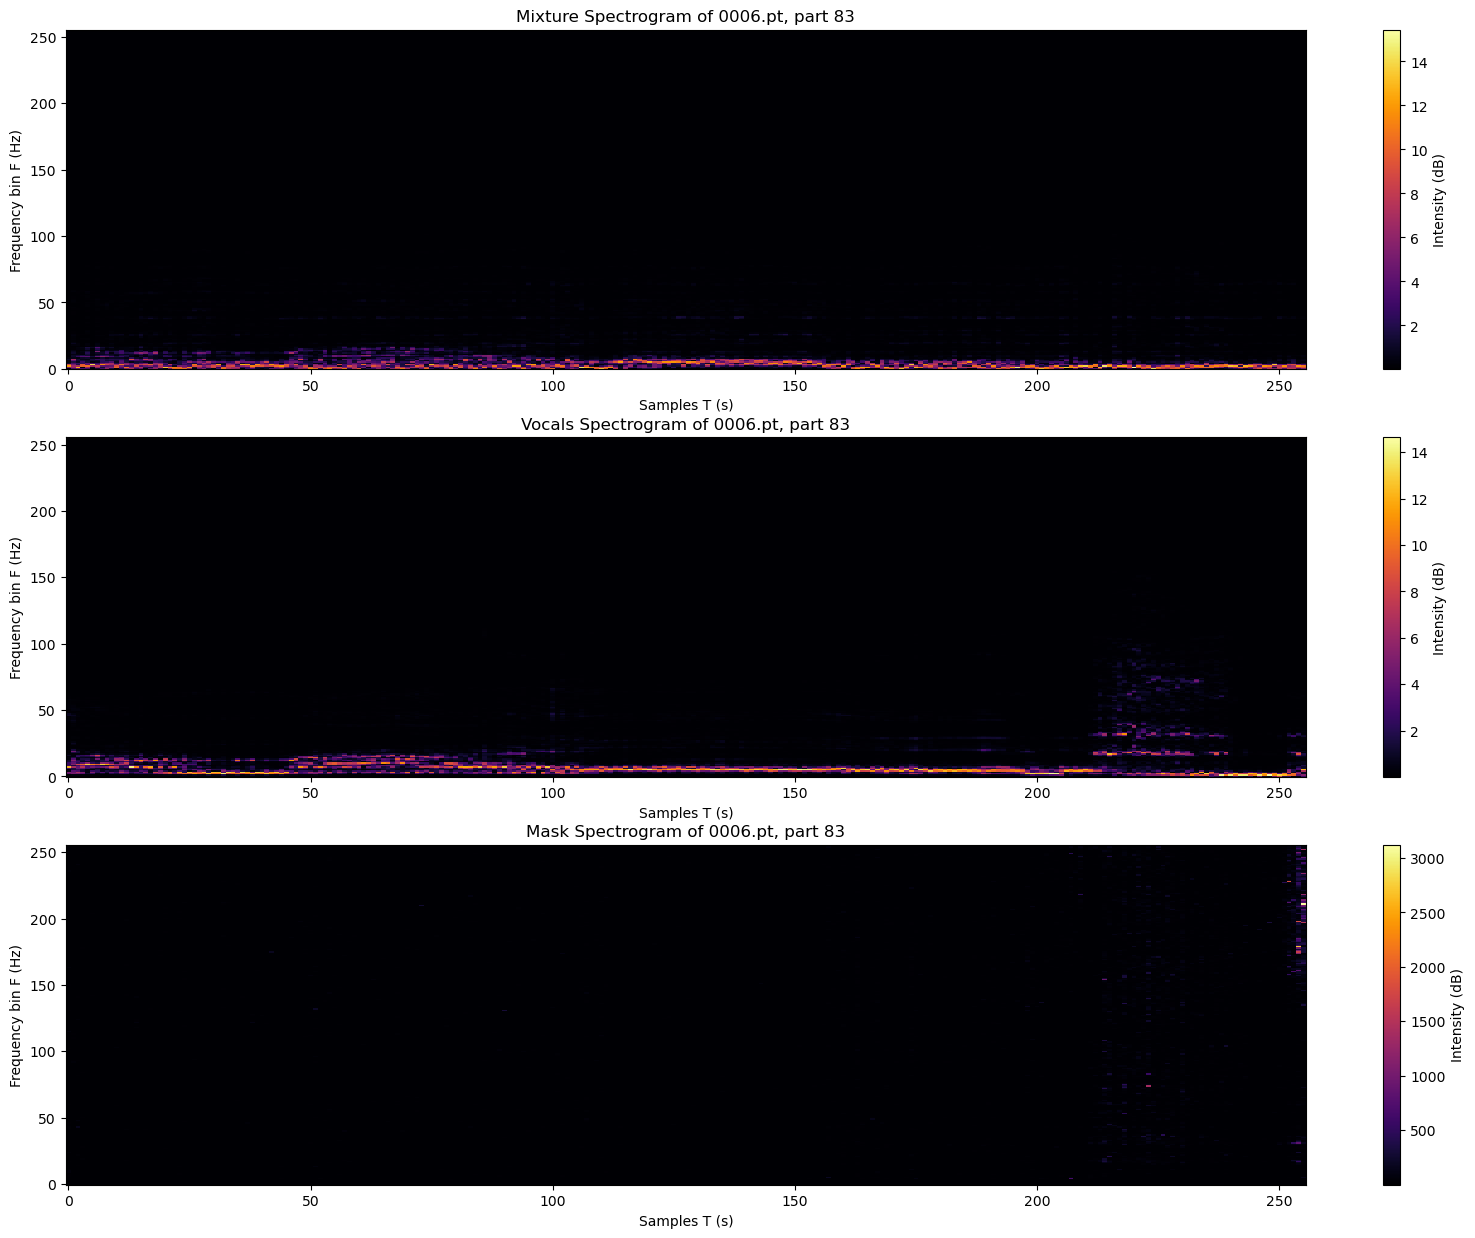

In [6]:
# Show how the transform has impacted the image / spectrogram
music_dataset_cpu.show_spectrogram(index=400)

# 3. Create DataLoader

In [7]:
#train_dataloader = torch.utils.data.DataLoader(music_dataset_train, batch_size=8, shuffle=True)
#val_dataloader = torch.utils.data.DataLoader(music_dataset_val, batch_size=8, shuffle=True)
#test_dataloader = torch.utils.data.DataLoader(music_dataset_test, batch_size=8, shuffle=True)
cpu_dataloader = torch.utils.data.DataLoader(music_dataset_cpu, batch_size=8, shuffle=True)

# 4. Load UNET Model + Weights + Freeze encoder

In [8]:
from model import UnetModel

# Set the device which shoult host the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create instance of model
model = UnetModel()
model.transfer_weights(weight_path='./music_data/unet_latest.pth',device=device)
model.freeze_encoder_weights()

Loading weights for UNet


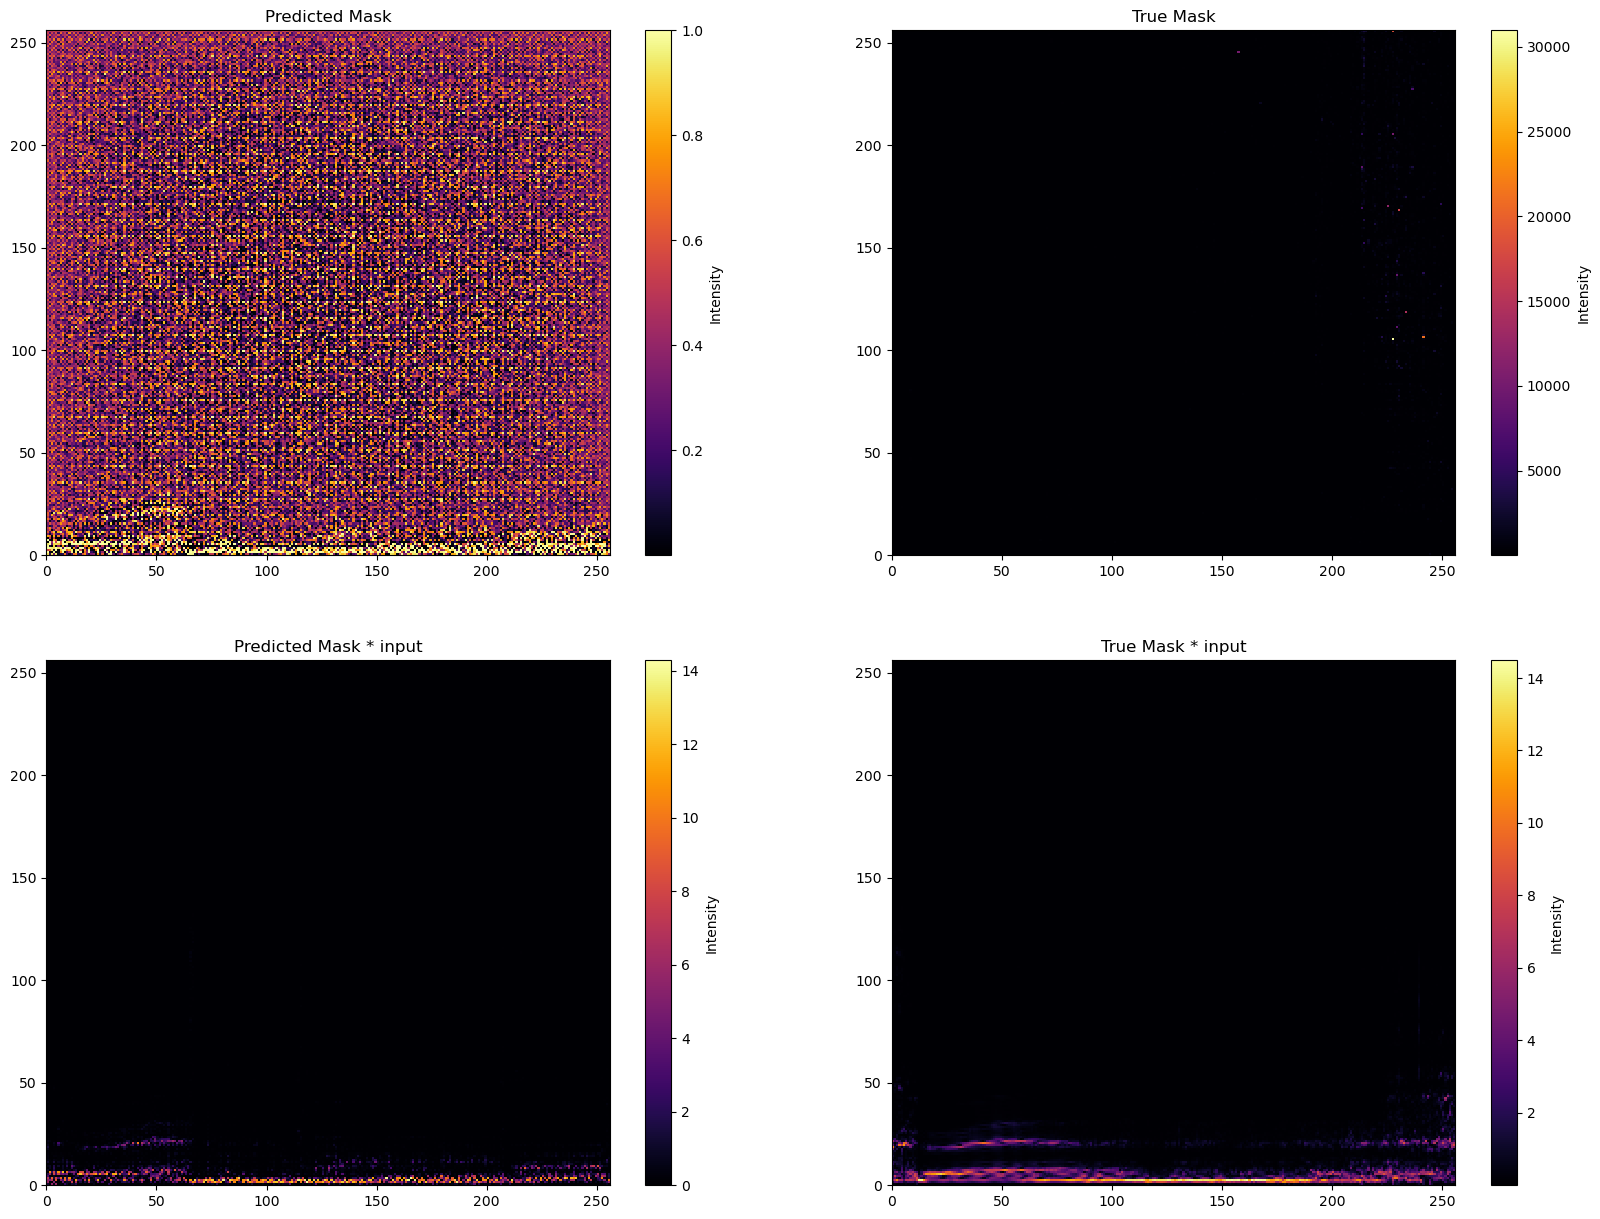

In [9]:
def show_pred_mask(pred_mask: torch.tensor, input_spectrogram: MUSDB18Spectrogram):
    pred_mask = pred_mask.squeeze().cpu().detach().numpy()  # Convert to NumPy array if it's a PyTorch tensor
    true_mask = input_spectrogram.mask.squeeze().cpu().detach().numpy()  # Assuming input_spectrogram.mask is a PyTorch tensor
    input_mix = input_spectrogram.mix.squeeze().numpy()

    # Plot the masks
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))

    # Plot the predicted mask
    im1 = axes[0][0].pcolormesh(pred_mask, cmap='inferno')
    axes[0][0].set_title('Predicted Mask')
    plt.colorbar(im1, ax=axes[0][0], label='Intensity')

    # Plot the true mask
    im2 = axes[0][1].pcolormesh(true_mask, cmap='inferno')
    axes[0][1].set_title('True Mask')
    plt.colorbar(im2, ax=axes[0][1], label='Intensity')

    # Plot the true mask
    im3 = axes[1][0].pcolormesh(pred_mask*input_mix, cmap='inferno')
    axes[1][0].set_title('Predicted Mask * input')
    plt.colorbar(im3, ax=axes[1][0], label='Intensity')

    # Plot the true mask
    im4 = axes[1][1].pcolormesh(true_mask*input_mix, cmap='inferno')
    axes[1][1].set_title('True Mask * input')
    plt.colorbar(im4, ax=axes[1][1], label='Intensity')

    plt.show()

a, b = music_dataset_cpu[5]
input_spectrogram = music_dataset_cpu.data[5]
mask_pred = model.forward(a[None, :])[0,0,:,:]

show_pred_mask(mask_pred, input_spectrogram)
        

# 5. Train model

In [10]:
from trainer import UnetTrainer

# Create an Unet trainer with the dataloaders.
trainer = UnetTrainer(model=model, train_dataloader=cpu_dataloader, val_dataloader=cpu_dataloader)

# Start training
improved_model, epoch_losses = trainer.train_model(num_epochs=10)

Starting training
Training on device: cpu
Epoch number 1 complete: Average loss: 0.658477030583282
Epoch number 2 complete: Average loss: 0.589143069377586
Epoch number 3 complete: Average loss: 0.5592035513315627
Epoch number 4 complete: Average loss: 0.5491719067986331
Epoch number 5 complete: Average loss: 0.5349182766764912
Epoch number 6 complete: Average loss: 0.5345430423074694
Epoch number 7 complete: Average loss: 0.5130898432055516
Epoch number 8 complete: Average loss: 0.5122156392282514
Epoch number 9 complete: Average loss: 0.5029807264235482
Epoch number 10 complete: Average loss: 0.4956611390434094
Training complete.


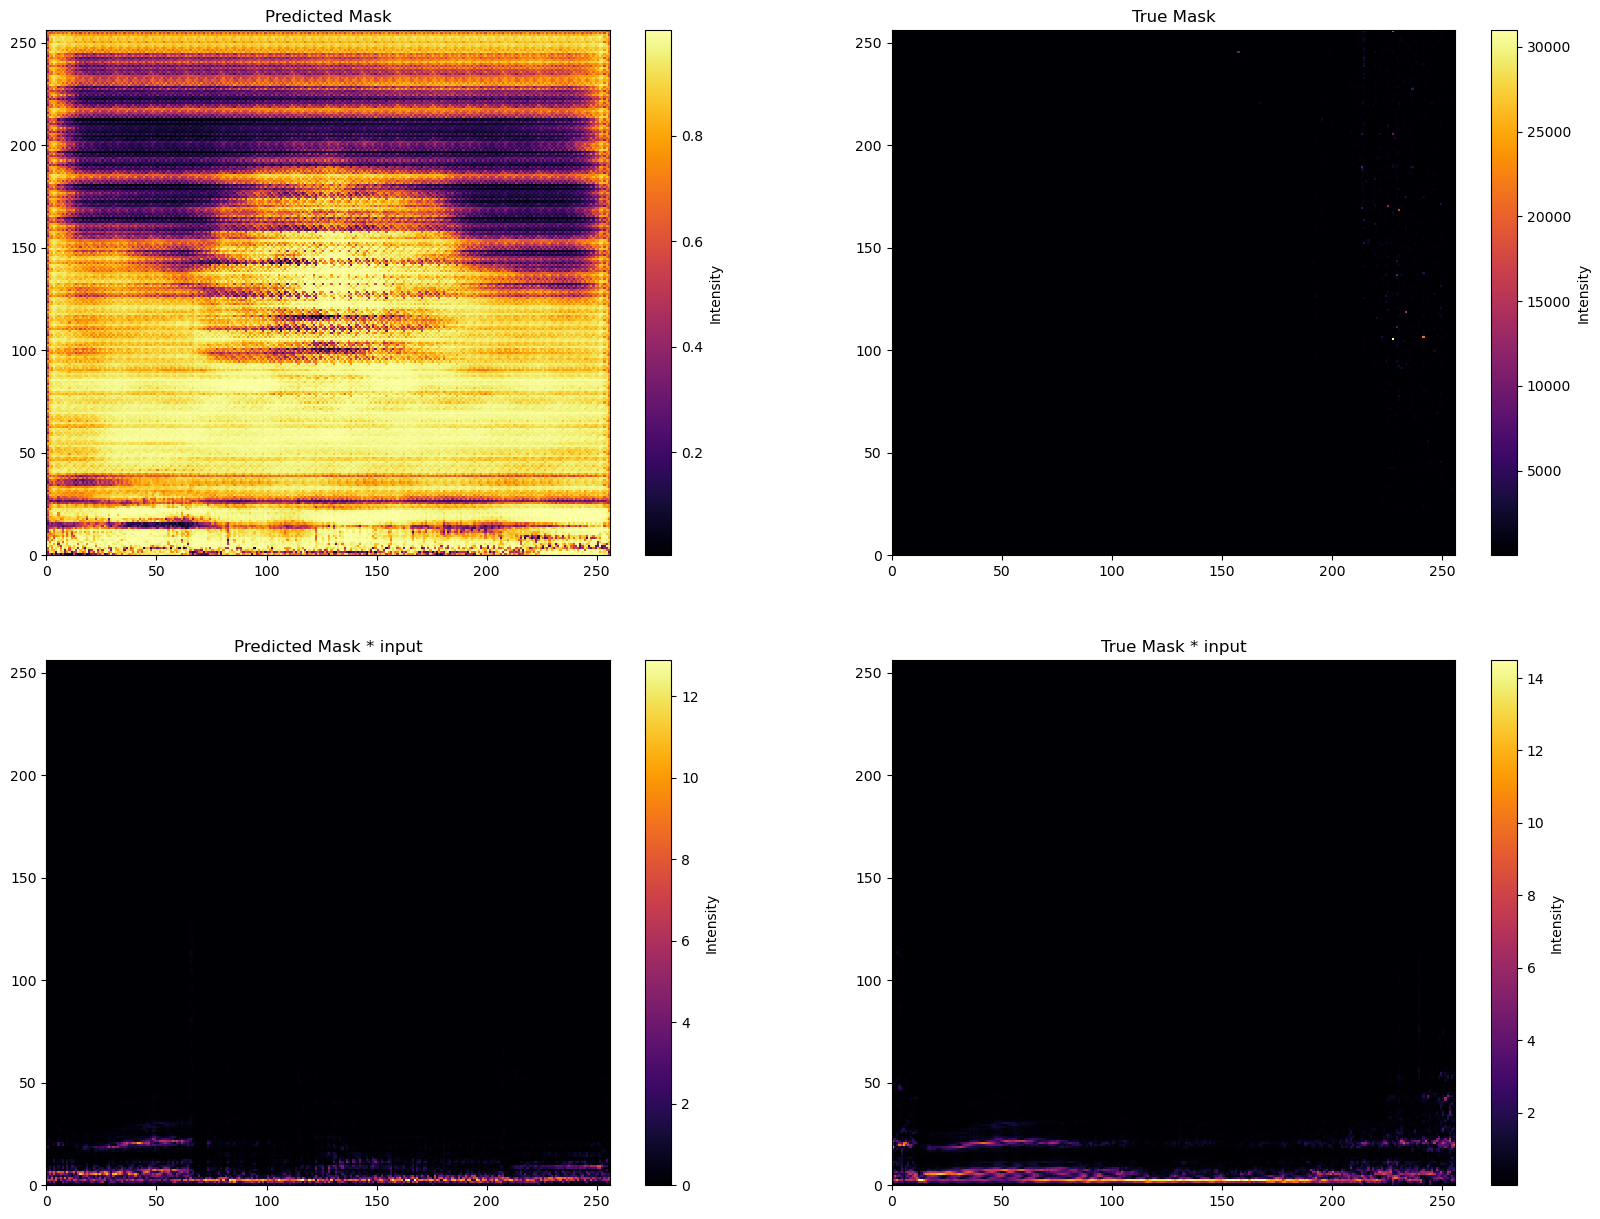

In [11]:
a, b = music_dataset_cpu[5]
input_spectrogram = music_dataset_cpu.data[5]
mask_pred = improved_model.forward(a[None, :])[0,0,:,:]

show_pred_mask(mask_pred, input_spectrogram)

# 6. Save trained model

In [12]:
torch.save({
            'model_state_dict': improved_model.state_dict(),
            'loss': epoch_losses,
            }, 'trained_model.pt')